Stand: 02.03.25

### Fragestellung: Gibt es andere DWD-Messstellen in der Nähe von Konstanz

1) Herausfinden welche Messstellen relevant sein könnten
2) Vergleichen der Werte mit Konstanz -> sieht man einen Unterschied beim Wechsel des Standortes ab dem 19.10.2020?

In [1]:
from bokeh.palettes import Viridis
from io import StringIO, BytesIO
import locale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import requests
import zipfile

# meine eigenen Funktionen 
from utils import dwd_functions as dwd_func

locale.setlocale(locale.LC_ALL, 'deu_deu')

c:\Users\majaf\miniconda3\envs\sensor-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'German_Germany.1252'

### 1 a) Einlesen der DWD-Datei über die Messstationen

In [2]:
url_stationen = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/TU_Stundenwerte_Beschreibung_Stationen.txt'

stationen_df = dwd_func.get_meta_dwd_stationen(url_stationen)
stationen_df.head(15)

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
0,3,1950-04-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1,44,2007-04-01,2025-03-06,44,52.9336,8.2370,Großenkneten,Niedersachsen
2,52,1976-01-01,1988-01-01,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
3,71,2009-12-01,2019-12-31,759,48.2156,8.9784,Albstadt-Badkap,Baden-Württemberg
4,73,2007-04-01,2025-03-06,374,48.6183,13.0620,Aldersbach-Kramersepp,Bayern
5,78,2004-11-01,2025-03-06,64,52.4853,7.9125,Alfhausen,Niedersachsen
6,91,2004-09-01,2025-03-06,304,50.7446,9.3450,Alsfeld-Eifa,Hessen
7,96,2019-04-09,2025-03-06,50,52.9437,12.8518,Neuruppin-Alt Ruppin,Brandenburg
8,102,2002-01-01,2024-09-02,0,53.8633,8.1275,Leuchtturm Alte Weser,Niedersachsen
9,106,1999-01-01,2006-12-01,500,51.7976,10.4429,Altenau,Niedersachsen


### 1 b) Filtern des DataFrames nach relevanten stationen

- sortieren nach Entfernung
- filtern nach dem Zeitraum -> wo sind Daten vom 01.01.2017 bis 13.12.2024 
- filtern nach ähnlicher Stationshöhe von 428 m

In [3]:
"""
    Berechnung und sortieren nach der Entfernung zu Konstanz
"""

# Daten Messstation DWD Konstanz:
ziel_station = stationen_df[stationen_df["Stationsname"] == "Konstanz"]

ziel_lat = ziel_station['geoBreite'].values[0]
ziel_lon = ziel_station['geoLaenge'].values[0]



# Entfernung berechnen und neue Spalte hinzufügen
stationen_df['Entfernung_km'] = stationen_df.apply(
    lambda row: dwd_func.haversine(ziel_lat, ziel_lon, row['geoBreite'], row['geoLaenge']),
    axis=1
)

# Sortieren nach Entfernung
stationen_df = stationen_df.sort_values('Entfernung_km')



"""
    Filtern nach dem Datum

"""

start = pd.Timestamp('2017-01-01')
ende = pd.Timestamp('2024-12-31')

relevant_stations = stationen_df[
    (stationen_df['von_datum'] <= start) & 
    (stationen_df['bis_datum'] >= ende)
]

"""
    Filtern nach Stationshöhe

"""

ziel_hoehe = ziel_station["Stationshoehe"].values[0]

relevant_stations = relevant_stations[
    (stationen_df['Stationshoehe'] <= ziel_hoehe + 80) & 
    (stationen_df['Stationshoehe'] >= ziel_hoehe - 80)
    ]

# Ergebnis anzeigen
print("\nDie 5 Stationen mit richtigem Zeitraum und die nahe dran sind an Konstanz und auf ähnlicher Höhe liegen: \n")
display(relevant_stations.head(5))


Die 5 Stationen mit richtigem Zeitraum und die nahe dran sind an Konstanz und auf ähnlicher Höhe liegen: 



C:\Users\majaf\AppData\Local\Temp\ipykernel_11456\1753147138.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_stations = relevant_stations[


,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,Entfernung_km
268,2712,1971-01-01,2025-03-06,428,47.6952,9.1307,Konstanz,Baden-Württemberg,0.000000
582,6258,2003-01-01,2025-03-06,461,47.6845,9.4409,Friedrichshafen-Unterraderach,Baden-Württemberg,23.248964
586,6263,2004-07-01,2025-03-06,445,47.7738,8.8219,Singen,Baden-Württemberg,24.692402
405,4094,2004-06-01,2025-03-06,441,47.8062,9.6206,"Weingarten, Kr. Ravensburg",Baden-Württemberg,38.649952
458,4704,2005-05-01,2025-03-06,508,47.5776,9.7404,Sigmarszell-Zeisertsweiler,Bayern,47.517441


### 2) Vergleichen der Werte mit Konstanz
- herunterladen der anderen Werte
- vergleichen mit Konstanz

In [9]:
station_id = '06258'
start_jahr = 2017
end_jahr = 2024
n_years = 1 + (end_jahr - start_jahr)
#[*Turbo256[0:n_years]]; [*RdYlBu[n_years]]
color_list = [*Viridis[n_years]]

base_url = f'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/'
url_akt = base_url + f'recent/tageswerte_KL_{station_id}_akt.zip'
url_hist = dwd_func.get_historical_url(station_id, base_url + 'historical/')

dwd_Friedrichshafen = dwd_func.combine_historical_recent_dwd(url_akt, url_hist)
dwd_Friedrichshafen.dropna(axis=1, how='all', inplace=True)
dwd_Friedrichshafen.drop(columns='eor', inplace=True)
display(dwd_Friedrichshafen.head())

Gefundene Datei: produkt_klima_tag_20230904_20250306_06258.txt
Gefundene Datei: produkt_klima_tag_20030101_20231231_06258.txt


,SOURCE,STATIONS_ID,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,TMK,UPM,TXK,TNK,TGK
MESS_DATUM,,,,,,,,,,,,,,
2003-01-01,dwd_hist,6258,10,1.7,4.0,NaN,0.0,6.0,8.2,7.4,81.0,9.9,5.7,3.3
2003-01-02,dwd_hist,6258,10,11.8,4.0,NaN,0.0,6.3,10.0,10.5,79.0,13.8,7.4,5.7
2003-01-03,dwd_hist,6258,10,8.5,4.0,NaN,0.0,6.7,7.3,8.1,68.0,10.2,6.0,4.6
2003-01-04,dwd_hist,6258,10,5.2,4.0,NaN,0.0,8.0,8.2,5.8,89.0,7.5,1.7,1.0
2003-01-05,dwd_hist,6258,10,1.5,4.0,0.0,0.0,8.0,4.8,-1.6,85.0,1.7,-3.4,-5.1


In [10]:
station_id = "06263"

url_akt = base_url + f'recent/tageswerte_KL_{station_id}_akt.zip'
url_hist = dwd_func.get_historical_url(station_id, base_url + 'historical/')

dwd_Singen = dwd_func.combine_historical_recent_dwd(url_akt, url_hist)
dwd_Singen.dropna(axis=1, how='all', inplace=True)
dwd_Singen.drop(columns='eor', inplace=True)
display(dwd_Singen.head())

Gefundene Datei: produkt_klima_tag_20230904_20250306_06263.txt
Gefundene Datei: produkt_klima_tag_20040701_20231231_06263.txt


,SOURCE,STATIONS_ID,QN_4,RSK,RSKF,SHK_TAG,NM,VPM,TMK,UPM,TXK,TNK,TGK
MESS_DATUM,,,,,,,,,,,,,
2004-07-01,dwd_hist,6263,10,2.5,4,0.0,7.7,11.8,16.6,64.0,22.5,10.6,9.1
2004-07-02,dwd_hist,6263,10,1.3,4,0.0,5.7,11.6,15.6,68.0,21.4,11.0,9.7
2004-07-03,dwd_hist,6263,10,0.0,0,0.0,6.0,10.6,15.8,62.0,22.0,10.1,9.2
2004-07-04,dwd_hist,6263,10,0.0,0,0.0,0.7,10.9,17.4,59.0,25.6,7.7,6.3
2004-07-05,dwd_hist,6263,10,6.2,4,0.0,7.0,14.8,17.6,75.0,25.3,10.1,8.8


In [17]:
station_id = "04094"

url_akt = base_url + f'recent/tageswerte_KL_{station_id}_akt.zip'
url_hist = dwd_func.get_historical_url(station_id, base_url + 'historical/')

dwd_Weingarten = dwd_func.combine_historical_recent_dwd(url_akt, url_hist)
dwd_Weingarten.dropna(axis=1, how='all', inplace=True)
dwd_Weingarten.drop(columns='eor', inplace=True)
display(dwd_Weingarten.head())

Gefundene Datei: produkt_klima_tag_20230904_20250306_04094.txt
Gefundene Datei: produkt_klima_tag_19460101_20231231_04094.txt


,SOURCE,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK
MESS_DATUM,,,,,,,,,,,,,,,,,,
1946-01-01,dwd_hist,4094,NaN,NaN,NaN,5,0.0,0,NaN,0.0,0.7,3.9,966.8,-5.0,90.0,-2.0,-7.3,NaN
1946-01-02,dwd_hist,4094,NaN,NaN,NaN,5,0.0,0,NaN,0.0,4.7,3.5,973.2,-5.4,84.0,-4.5,-7.0,NaN
1946-01-03,dwd_hist,4094,NaN,NaN,NaN,5,0.0,0,NaN,0.0,0.0,3.1,975.0,-6.4,82.0,-4.0,-8.4,NaN
1946-01-04,dwd_hist,4094,NaN,NaN,NaN,5,0.0,0,NaN,0.0,1.3,2.9,974.8,-7.8,83.0,-3.5,-10.0,NaN
1946-01-05,dwd_hist,4094,NaN,NaN,NaN,5,0.0,0,NaN,0.0,5.3,3.7,973.0,-6.2,96.0,-4.9,-12.4,NaN


In [13]:
station_id = "02712"

url_akt = base_url + f'recent/tageswerte_KL_{station_id}_akt.zip'
url_hist = dwd_func.get_historical_url(station_id, base_url + 'historical/')

dwd_Konstanz = dwd_func.combine_historical_recent_dwd(url_akt, url_hist)
dwd_Konstanz.dropna(axis=1, how='all', inplace=True)
dwd_Konstanz.drop(columns='eor', inplace=True)
display(dwd_Konstanz.head())

Gefundene Datei: produkt_klima_tag_20230904_20250306_02712.txt
Gefundene Datei: produkt_klima_tag_19590701_20231231_02712.txt


,SOURCE,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK
MESS_DATUM,,,,,,,,,,,,,,,,,,
1959-07-01,dwd_hist,2712,5,11.8,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-07-02,dwd_hist,2712,5,8.8,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-07-03,dwd_hist,2712,5,14.2,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-07-04,dwd_hist,2712,5,5.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-07-05,dwd_hist,2712,5,4.4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


!! Bisher sind es hier nur tägliche Werte vom DWD -> besser wären Stundenwerte und dann je ein Diagramm für Tag und Nacht miteinder vergleichen

Am 19.10.2020 war der Standortwechsel -> man sieht, dass davor häufiger Spitzen bei Konstanz waren 

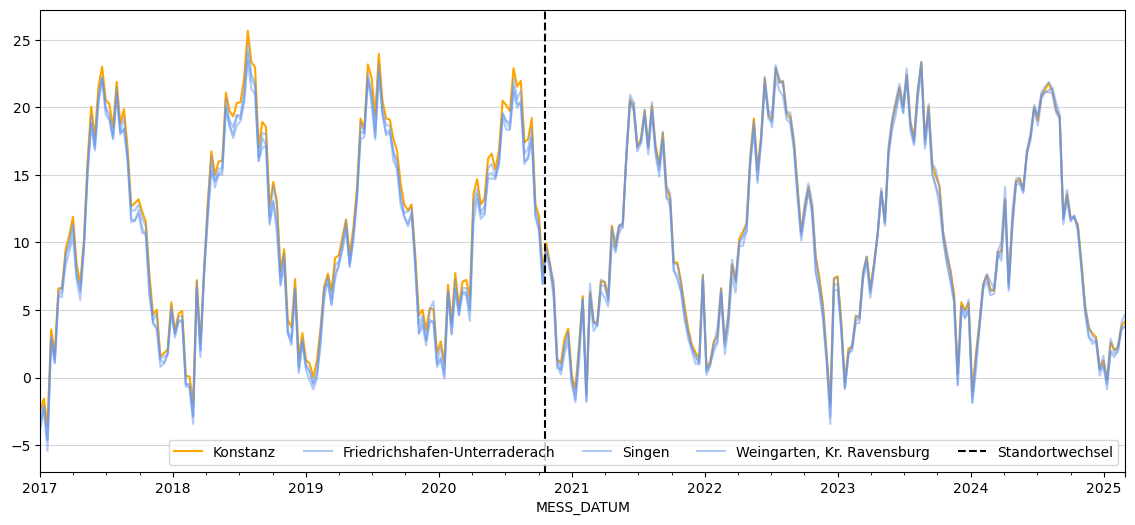

In [37]:
start = "2017"
ende = "2025"
color = "cornflowerblue"
dwd_Konstanz["TMK"].loc[start:ende].resample("10D").mean().plot(figsize=(14,6), label ="Konstanz", color="orange")
dwd_Friedrichshafen["TMK"].loc[start:ende].resample("10D").mean().plot(label="Friedrichshafen-Unterraderach", alpha=0.5, color=color)
dwd_Singen["TMK"].loc[start:ende].resample("10D").mean().plot(figsize=(14,6), label="Singen",alpha=0.5, color=color)
dwd_Weingarten["TMK"].loc[start:ende].resample("10D").mean().plot(figsize=(14,6), label="Weingarten, Kr. Ravensburg",alpha=0.5, color=color)
plt.axvline(pd.Timestamp("2020-10-19"), color="black", linestyle="--", label="Standortwechsel")
plt.grid(alpha=0.5, axis='y')
plt.legend(ncol=5)

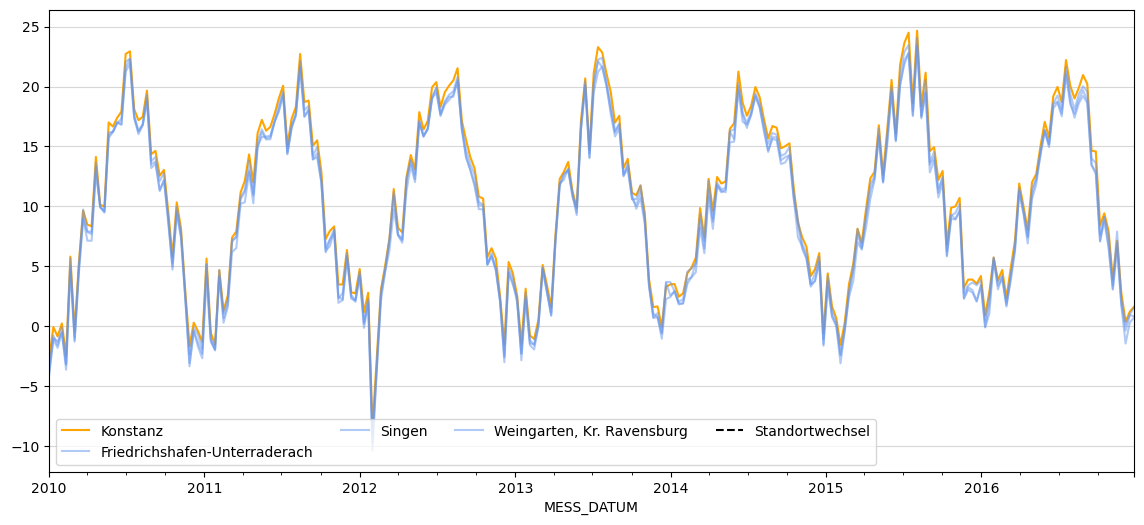

In [36]:
start = "2010"
ende = "2016"
dwd_Konstanz["TMK"].loc[start:ende].resample("10D").mean().plot(figsize=(14,6), label ="Konstanz", color="orange")
dwd_Friedrichshafen["TMK"].loc[start:ende].resample("10D").mean().plot(label="Friedrichshafen-Unterraderach", alpha=0.5, color=color)
dwd_Singen["TMK"].loc[start:ende].resample("10D").mean().plot(figsize=(14,6), label="Singen", alpha=0.5, color=color)
dwd_Weingarten["TMK"].loc[start:ende].resample("10D").mean().plot(figsize=(14,6), label="Weingarten, Kr. Ravensburg", alpha=0.5, color=color)
plt.axvline(pd.Timestamp("2020-10-19"), color="black", linestyle="--", label="Standortwechsel")
plt.grid(alpha=0.5, axis='y')
plt.legend(ncol=4)

## 3) Prophet für Zeitreihenanalyse

In [38]:
dwd_Konstanz.loc["1973":, "TMK"].resample('Y').mean().head(25)

C:\Users\majaf\AppData\Local\Temp\ipykernel_22992\2448023099.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dwd_Konstanz.loc["1973":, "TMK"].resample('Y').mean().head(25)


MESS_DATUM
1973-12-31     8.903836
1974-12-31     9.590959
1975-12-31     9.437260
1976-12-31     9.430328
1977-12-31     9.593151
1978-12-31     8.585205
1979-12-31     9.113151
1980-12-31     8.393716
1981-12-31     9.209589
1982-12-31     9.650411
1983-12-31     9.784110
1984-12-31     8.832514
1985-12-31     8.687123
1986-12-31     9.043562
1987-12-31     8.836712
1988-12-31     9.979235
1989-12-31     9.971233
1990-12-31    10.248767
1991-12-31     9.379452
1992-12-31    10.227049
1993-12-31     9.661918
1994-12-31    10.794795
1995-12-31     9.863836
1996-12-31     8.784973
1997-12-31     9.922740
Freq: YE-DEC, Name: TMK, dtype: float64

10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:38 - cmdstanpy - INFO - Chain [1] done processing


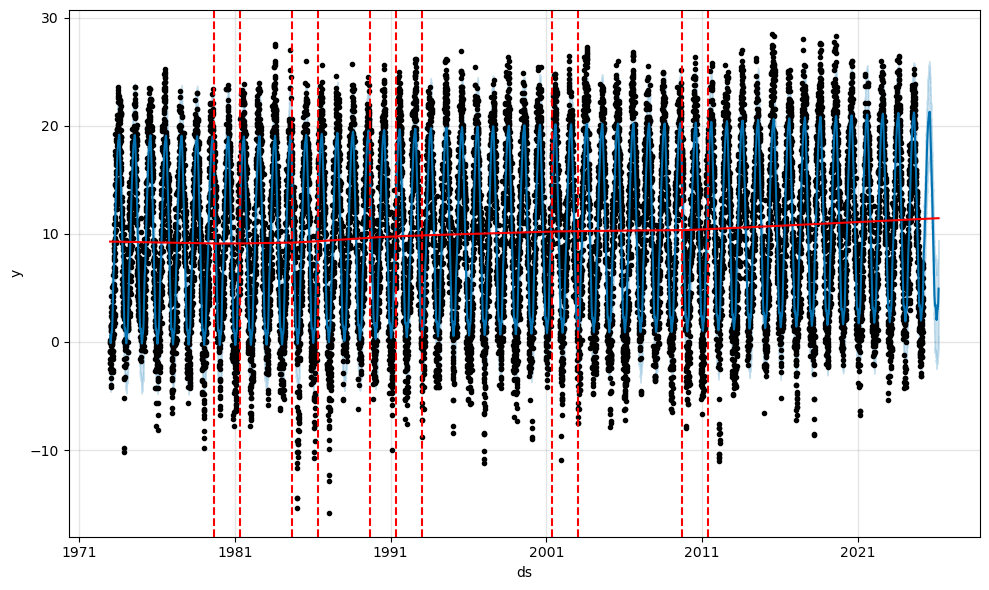

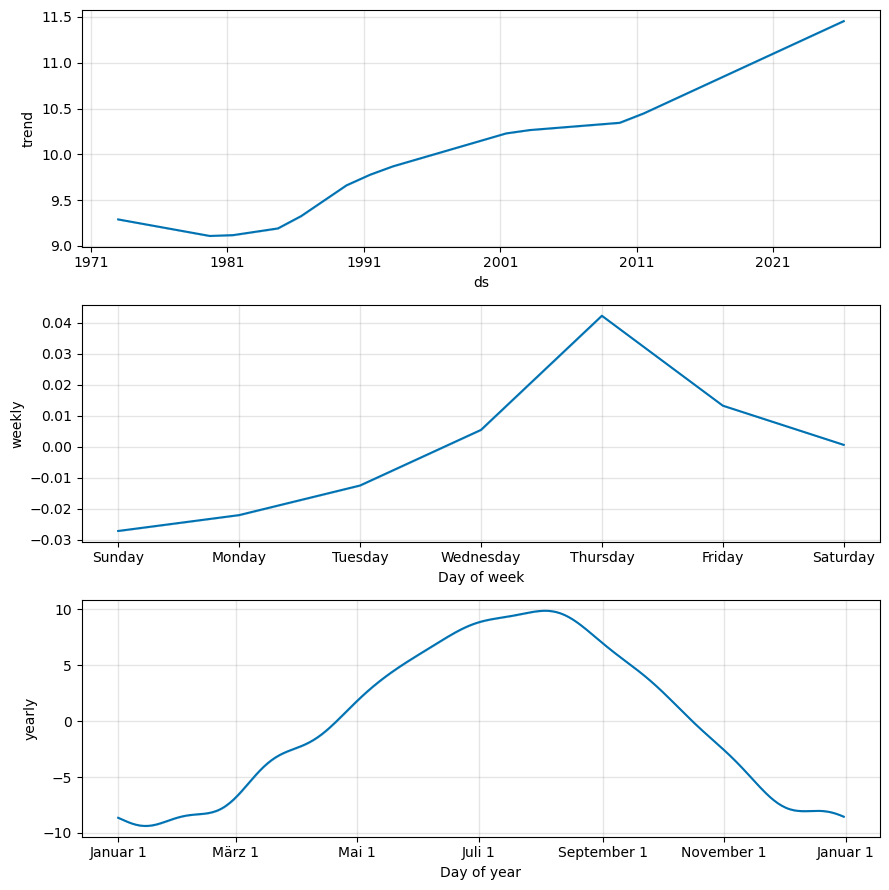

In [41]:
#dwd_Friedrichshafen, dwd_Konstanz, dwd_Singen
# dwd_Konstanz["TMK"] hat erst ab 1973 Werte gute Werte
# dwd_Konstanz.loc["1973":, "TMK"]
df = dwd_Konstanz.loc["1973":, "TMK"].reset_index().rename(columns={"MESS_DATUM": "ds", "TMK": "y"})
df.head()

m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
#display(future.tail())

forecast = m.predict(future)
#display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

fig2 = m.plot_components(forecast)